In [1]:
using Gen
using Distributions
using Random
using Plots

In [ ]:
@gen function seir_model_complete(T::Int, N::Int)
    # Latent parameters with priors
    β ~ beta(2, 3)   # transmission probability
    σ ~ beta(2, 5)   # incubation rate
    γ ~ beta(2, 8)   # recovery rate

    # Initial states
    S = N - 1
    E = 0
    I = 1
    R = 0

    infected_counts = Int[]

    for t in 1:T
        # Probabilities
        infection_prob  = min(β * I / N, 1.0)
        incubation_prob = σ
        recovery_prob   = γ

        # Transitions using Binomial counts
        new_E = @trace(binom(S, infection_prob), (:new_E, t))
        new_I = @trace(binom(E, incubation_prob), (:new_I, t))
        new_R = @trace(binom(I, recovery_prob), (:new_R, t))

        # Update compartments
        S -= new_E
        E += new_E - new_I
        I += new_I - new_R
        R += new_R

        # Observation tied to infectious individuals
        obs = @trace(poisson(I), (:obs, t))
        push!(infected_counts, obs)

        @assert S + E + I + R == N  # sanity check
    end

    return infected_counts
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##seir_model_complete#289", Bool[0, 0], false)

In [26]:
Random.seed!(4)

T = 100
N = 100

(trace, _) = generate(seir_model_complete, (T, N))


println("Observations:")
println(get_retval(trace))

println("\nLatent parameters:")
println("β = ", trace[:β])
println("σ = ", trace[:σ])
println("γ = ", trace[:γ])


Observations:
[1, 2, 2, 1, 1, 3, 3, 4, 5, 6, 9, 11, 13, 17, 17, 21, 28, 37, 42, 45, 55, 55, 58, 58, 61, 62, 57, 56, 55, 53, 54, 55, 56, 52, 51, 45, 44, 43, 40, 36, 33, 31, 29, 27, 27, 26, 25, 22, 22, 21, 20, 20, 17, 16, 14, 14, 13, 11, 11, 10, 10, 10, 8, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Latent parameters:
β = 0.8358484962604672
σ = 0.2519623991527895
γ = 0.048477374048150904


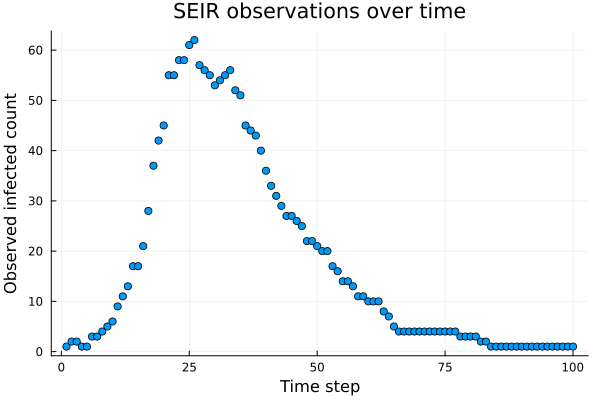

In [27]:
obs = get_retval(trace)

scatter(
    1:length(obs),
    obs,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time",
    legend = false
)
